In [77]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)
options(warn=-1)
setwd("C://Doc/19spring/STAT628/Module1")
if(!require("faraway")){
    install.packages("faraway")
}
if(!require("leaps")){
    install.packages("leaps")
}
if(!require(plotmo)){
    install.package("plotmo")
}
if(!require(glmnet)){
    install.package("glmnet")
}
if(!require(corrplot)){
    install.package("corrplot")
}
require(plotmo)
require(corrplot)
require(glmnet)
library(leaps)
library(faraway)
library(repr)
options(warn=-1)

# Introduction
Body fat percentage, a measure of obesity, plays an important role in various health outcomes but it's costly to get accurate value. Our goal is to build a simple, robust, accurate and explainable model to predict body fat percentage. Finally, we find a 'rules of thumb' method to calculate bady fat percentage with three variables.

# Background
The data set has 252 observations and 16 variables. Bodyfat is the dependent variable and since the underwater body density is technically hard to measure under common condition, we have 14 readily available clinical body measurements to estimate bodyfat. 
All of observations are men and we learned that abdomen is a key independent variable from google and a normal male's bodyfat should not smaller than 2.

# Data Cleaning

Based on the background research, the range of bodyfat for a male athlete should not be lower than 2%-5%, and the range of bodyfat for a female athlete should not be lower than 10%-12%. We checked the data and there are two people whose bodyfat is lower than 2. Their number are 172 and 182. We decided to remove these abnormal people.

In [12]:
BodyFat = read.table("BodyFat.csv", sep = ",", header = T)
BodyFat = BodyFat[,-c(1,3)]
BodyFat$HEIGHT[42] <- 69.5
BodyFat$WEIGHT[221] <- 173.25
BodyFat$WEIGHT[163] <- 164.25
BodyFat <- BodyFat[-c(182,172,39),]
height <- BodyFat$HEIGHT / 39.37007874
weight <- BodyFat$WEIGHT * 0.453592
BMI <- weight / (height^2)
BMI_diff <- NULL
for (i in 1:length(BMI)) {
  BMI_diff[i] <- BMI[i] - BodyFat$ADIPOSITY[i]
  if (BMI_diff[i] > 0.1|BMI_diff[i] < -0.1){
    #print(paste0("i = ",i,"      BMI_difference = ",BMI_diff[i]))
  }
}
model <- lm(BodyFat$BODYFAT ~ ., data=BodyFat)
par(mar = c(2, 2, 0.1, 0.1), cex = 0.8)
#plot(model, which = 4)

There are three obvious outliers which are 42, 163 and 221. We used the adiposity data and either the weight data or the height data to check why there exists the mistake. It turns out that the height of 42 should be 69.5 instead of 29.5, the weight of 163 should be 164.25 instead of 184.25, and the height of 221 should be 173.25 instead of 153.25. After modifying these three data, the mean difference between the calculated BMI and the Adiposity equals to -0.03, so We checked the data which absolute difference is greater than 0.1 which is three times bigger than the mean. There are 7 people whose BMI absolute difference is greater than 0.1, but none of them have an obvious input error. All of their height or weight is in the 1st quantile area.
Then I check the Cook's distance. We have to know that there always exists three extreme points, so we have to check whether the point is an outlier by ourself. For the 39 person,

In [14]:
BodyFat[39,]

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
40,31.3,50,203,67,31.8,40.2,114.8,108.1,102.5,61.3,41.1,24.7,34.1,31,18.3


He is a very heavy guy. He weights 363.15. So we decided to remove him from the model.
For the next extreme point number 86,

In [15]:
BodyFat[86,]

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
87,15,72,157.75,67.25,24.6,37.7,97.5,88.1,96.9,57.2,37.7,21.8,32.6,28,18.8


He is a tall but light person with all the other dimensions are relatively large, but no strong evidence shows that this is an outlier, so we decided to keep it. The person whose number is 192 is a person who is tall and heavy, so we decided to keep it based on the same reason. Then we checked whether there is a data point with high leverage.  
As we mentioned before, R will always shows us three extreme points. After we double checked the suspected outliers, we decided to keep all the data points.

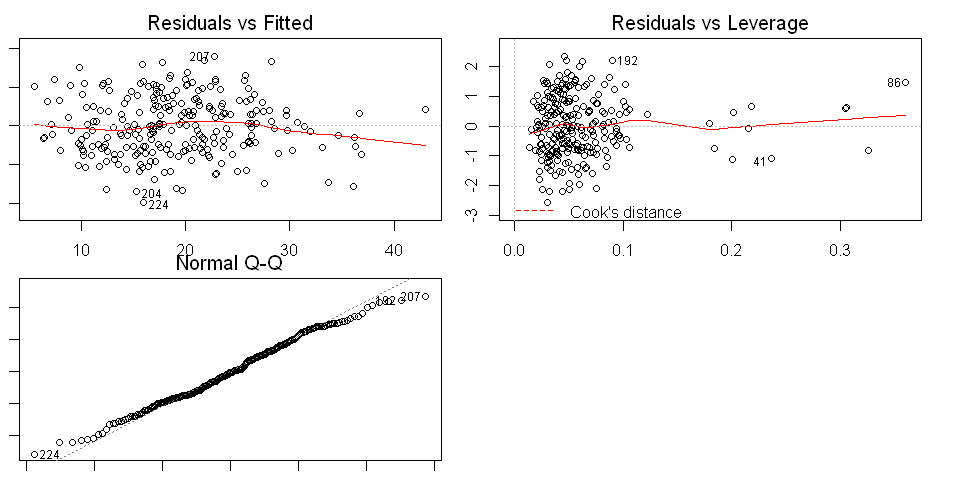

In [16]:
model <- lm(BodyFat$BODYFAT ~ ., data=BodyFat)
layout(matrix(1:4, ncol=2))
par(mar = c(1, 1, 2, 2), cex = 0.8)
plot(model,c(1,2,5))
options(repr.plot.width=8, repr.plot.height=4)

# Mallows's Cp
We know that Mallows's Cp is a method that is applied in the context of model selection, where a number of predictor variables are available for predicting some outcome, and the goal is to find the best model involving a subset of these predictors. So we chose Mallows's Cp as one of the method.

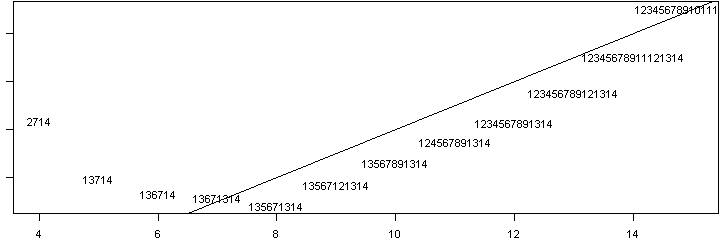

In [23]:
par(mar = c(2, 1, 0.1, 0.1), cex = 0.55)
model <- lm(BodyFat$BODYFAT ~ ., data=BodyFat)
X <- model.matrix(model)[,-1]
Y <- BodyFat[,1]
g <- leaps(X,Y, nbest=1)
Cpplot(g)
options(repr.plot.width=6, repr.plot.height=2)

For the Mallows's Cp method，it will calculate the cp value for several regression models. The cp value represents the accuracy(variance) of the model estimating the actual regression coefficient and predicting the future response. Smaller the cp value is, the more accuracy the model will be. However, the cp value also represents the degree of deviation. Closer the cp value is to the number of variances plus a constant p, the model is relatively more unbiased. The line in the previous plot represents the number of variables plus a constant p, so what we are going to choose is the model which is closest to the line. The best answer should be variable: age, height, chest, abdomen, forearm, wrist.  
We decided to give up the method at the end because this model is not as simple as the model selected by BIC.

In [336]:
cp_choice <- c(1,3,6,7,13,14)+1
BodyFat <- BodyFat[,c(1,cp_choice)]
model.cp <- lm(BodyFat$BODYFAT ~ ., data=BodyFat)

# Lasso Regression
Since Lasso regression penalize the coefficients with the same regulization. We need to regulize the features first. Lasso can eliminate the muticollinearity in a certain degree. However, it cannot tackle with the collinearity between authentic and noisy variables.$^{[1]}$ Thus we pick some variables according to our background research. We check the VIF and correlation of the selected variables. They donot have serious collinearity.  
Then we split the data into two parts. It can help us to choose a better $\lambda$.

In [87]:
rm(list=ls())
#data cleaning
BodyFat = read.table("BodyFat.csv", sep = ",", header = T)
BodyFat = BodyFat[,-1]
BodyFat = BodyFat[,-2]
BodyFat$HEIGHT[42] <- 69.5
BodyFat$WEIGHT[221] <- 173.25
BodyFat$WEIGHT[163] <- 164.25
BodyFat <- BodyFat[-c(182,172,39),]
#LASSO normalization
normalization <- function(datafr){
  if(ncol(datafr) > 1){
    new_dt <- as.data.frame(sapply(1:ncol(datafr), FUN = function(x)
      (datafr[,x]-min(datafr[,x]))/(max(datafr[,x]-min(datafr[,x])))))
    names(new_dt) <- names(datafr)
    return(new_dt)
  }else{
    return((datafr-min(datafr))/(max(datafr)-min(datafr)))
  }
}
unnormalization <- function(data_norm, data_raw){
  ###data_norm is the data before normalization, data_raw is the data after normalization
  if(ncol(data_raw) == 1){
    data_trans <- data_raw*(max(data_norm)-min(data_norm))+min(data_norm)
    return(data_trans)
  }
  if(!(ncol(data_norm) == ncol(data_raw))){
    stop("Size does not match")
  }
  if(ncol(data_norm)>1){
    data_trans = as.data.frame(sapply(1:ncol(data_raw), FUN = function(x) 
      data_raw[,x]*(max(data_norm)-min(data_norm))+min(data_norm)))
    names(data_trans) <- names(data_raw)
    return(data_trans)
  }
}
#Eliminating the muticollinearity
BodyFat = BodyFat[,c("BODYFAT","AGE","ABDOMEN","HEIGHT","KNEE","THIGH","ANKLE","BICEPS","FOREARM","WRIST")]
#corrplot::corrplot(cor(BodyFat),main="\n Correlation Plot",tl.cex=0.6)
#print("The VIF of the selected variables are:")
#car::vif(lm(BODYFAT~.,data=normalization(BodyFat)))
#data split
all_row = 1:nrow(BodyFat)
test = sample(all_row,nrow(BodyFat)*.2)
train = all_row[!(all_row %in% test)]
test = BodyFat[test,]
train = BodyFat[train,]
test_norm <- normalization(test)
train_norm <- normalization(train)    
options(repr.plot.width=8, repr.plot.height=2)

The VIF of the selected model are:  
AGE 2.08       ABDOMEN 3.65       HEIGHT 1.69       KNEE 4.17       THIGH 5.26       ANKLE 1.71       BICEPS 3.02       
FORARM 2.22     WRIST 2.61  
We try $\lambda$ from $log(-10)$ to $log(-1)$. The plot below is the MSE v.s $log(\lambda)$. Both train and test MSE increase as the $\lambda$ grows. It stops increasing when $\lambda$ is large enough to eliminate all coefficients. The trace plot of the coefficient shows that the number of features decrease as the lambda grows.  
The right-hand side plot show how coefficients behave as the lambda decreas. We will only keep 2 variables if we choose $\lambda=log(-4)$.

In [27]:
#Training lasso reg and select a best lambda
log_lambda_range <- seq(-10,-1,0.01)
MSE_train=c()
MSE_test = c()
for(log_lambda in log_lambda_range){
  fit.lasso <- glmnet(x=model.matrix(~.,train_norm[,-1]), y=train_norm[,1],
                      family="gaussian", alpha=1, lambda = exp(log_lambda))
  y_pred <- predict(fit.lasso, newx = model.matrix(~.,train_norm[,-1]))
  train_error = y_pred - train_norm[,1]
  MSE_train <- c(MSE_train, mean(train_error^2))
  y_pred <- predict(fit.lasso, newx = model.matrix(~.,test_norm[,-1]))
  test_error = y_pred - test_norm[,1]
  MSE_test = c(MSE_test, mean(test_error^2))
}

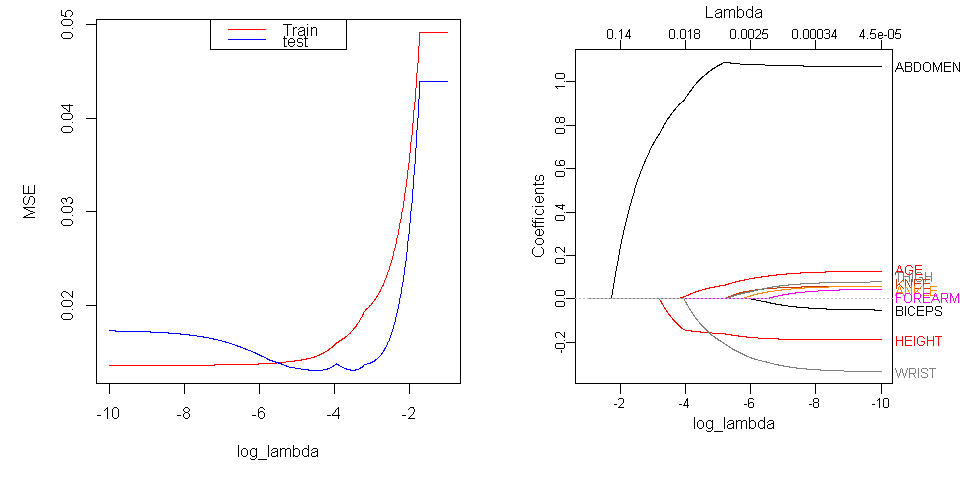

In [35]:
par(mfrow=c(1,2),mar = c(4, 4, 1, 1), cex = 0.8)
options(repr.plot.width=8, repr.plot.height=4)
#Plot MSE v.s lmabda
plot(log_lambda_range, MSE_train, col = 'red', type="line", xlab = "log_lambda",ylab="MSE",
     ylim=c(min(c(MSE_train,MSE_test)),max(c(MSE_train,MSE_test))))
lines(log_lambda_range, MSE_test, col = "blue", type="line")
legend("top", legend = c("Train", "test"), col = c("red","blue"), lty=1,cex=1)

#Plot the coefficients trace plot
model <- glmnet(x=model.matrix(~.,train_norm[,-1]), y=train_norm[,1],
                family="gaussian", alpha=1, lambda = exp(log_lambda_range))
plotmo::plot_glmnet(model,xlab="log_lambda")
options(warn=-1)

Then we check how MSE behave when using crossvalidation. The following plot shows that it donot have a large deviation when doing 10-folds crossvalidation. Take both MSE and model complexity into consideration, we choose $\lambda=log(-4)$ as the final Lasso model.  
We fit the lasso model on the whole dataset with $\lambda=log(-4)$. When we check the residuals, it shows some patterns. The model is not fitted well. The residuals stll contains lots of information. We also try differenct $\lambda$. The model does not fitted well until $\lambda>log(-6)$. But we have almost 8 variables when $\lambda$ reaches $log(-6)$. That's not an ideal model.
In summary, the Lasso model is not suitable for it.

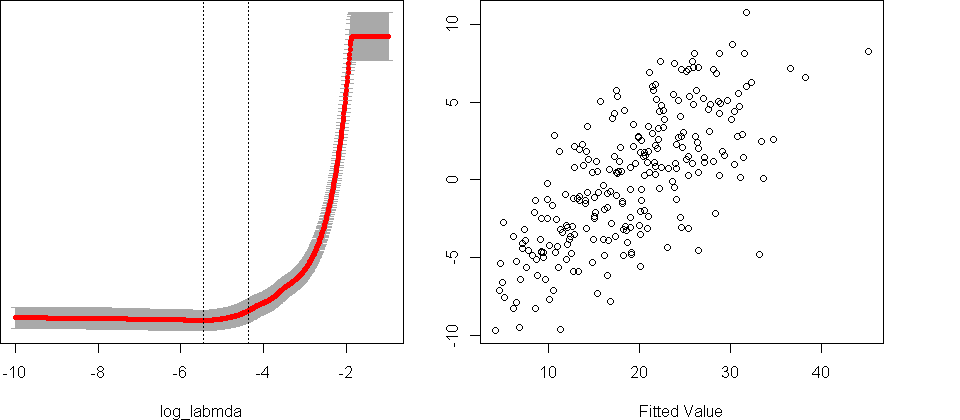

In [86]:
#cross validation model on the whole dataset
par(mfrow=c(1,2),mar = c(4, .01, .01, 4), cex = 0.8)
#options(repr.plot.width=1, repr.plot.height=1)
body_norm = normalization(BodyFat)
cv_model = cv.glmnet(x=model.matrix(~.,body_norm[,-1]), y=body_norm[,1],
                     family="gaussian", alpha=1, lambda = exp(log_lambda_range),
                     nfolds=10)
plot(cv_model,xlab="log_labmda")
options(repr.plot.width=8, repr.plot.height=3.5)
body_norm <- normalization(BodyFat)
model <- glmnet(x=model.matrix(~.,body_norm[,-1]), y=body_norm[,1],
             family="gaussian", alpha=1, lambda = exp(-4))
BodyFat_y <- predict(model, newx =  model.matrix(~.,body_norm[,-1])) 
BodyFat_y <- unnormalization(BodyFat$BODYFAT,BodyFat_y)
BodyFat_error <- BodyFat[,1]-t(BodyFat_y)
plot(BodyFat$BODYFAT,BodyFat_error,ylab = "Residuals",xlab="Fitted Value")

# Stepwise selection
## Akaike information criterion(AIC)
The all possible regression (APR) is a method to find the best subset of all features, but it is computationally expensive. Stepwise regression is a method of fitting regression models in which the choice of predictive variables is carried out by an automatic procedure.$^{[2]}$ We first try the stepwise regression with AIC.<br>
We tried forward, backward and Bidirectional elimination. All these models retain too much features. And these features have large VIF, which means they are strongly linear correlated. Thus we try a stronger penalty: BIC.

In [342]:
setwd("C://Doc/19spring/STAT628/Module1")
rm(list=ls())
#data cleaning
BodyFat = read.table("BodyFat.csv", sep = ",", header = T)
BodyFat = BodyFat[,-1]
BodyFat = BodyFat[,-2]
BodyFat$HEIGHT[42] <- 69.5
BodyFat$WEIGHT[221] <- 173.25
BodyFat$WEIGHT[163] <- 164.25
# BodyFat <- BodyFat[-c(182,172,39),]

full.model <- lm(BODYFAT ~., data = BodyFat)
reduce.model <- lm(BODYFAT~1,data=BodyFat)
# Stepwise regression model
step.model <- MASS::stepAIC(full.model, direction = "both", 
                      trace = F,scope=list(upper=full.model,lower=reduce.model))
for.model <- MASS::stepAIC(reduce.model, direction = "forward", 
                      trace = F,scope=list(upper=full.model,lower=reduce.model))
back.model <- MASS::stepAIC(full.model, direction = "backward", 
                      trace = F)
print("Bidirectional selection")
print(step.model$call)
print("Forward selection")
print(for.model$call)
print("Backward selection")
print(back.model$call)

[1] "Bidirectional selection"
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = BodyFat)
[1] "Forward selection"
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM + NECK + 
    AGE + THIGH + HIP, data = BodyFat)
[1] "Backward selection"
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = BodyFat)


## Bayesian information criterion(BIC)

In [343]:
#data after preprocessing
BodyFatClean <- read.table("BodyFat.csv", sep = ",", header = T)
df <- subset(BodyFatClean, select = -c(IDNO,DENSITY))
df1 = df
df1[42,4] = 69.5
df1[221,3] = 173.25
df1[163,3] = 164.25
df2 = df1[-c(39,172,182),]
df = df2
full.model <- lm(formula = BODYFAT ~ ., data = df)
reduce.model <- lm(formula = BODYFAT ~ 1, data = df)
BodyFat = df

we have learned that BIC tend to choose less variables than AIC so we use BIC to choose the best model.Three different directions are used but their outcomes are same. 

In [344]:
step.model <- MASS::stepAIC(full.model, direction = "both", trace = F,scope=list(upper=full.model,lower=reduce.model)
                            ,k=log(nrow(BodyFat)-1))
for.model <- MASS::stepAIC(reduce.model, direction = "forward", trace = F,scope=list(upper=full.model,lower=reduce.model)
                            ,k=log(nrow(BodyFat)-1))
back.model <- MASS::stepAIC(full.model, direction = "backward", trace = F,
                           k=log(nrow(BodyFat)-1))
print("Bidirectional selection")
print(step.model$call)
print("Forward selection")
print(for.model$call)
print("Backward selection")
print(back.model$call)

[1] "Bidirectional selection"
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = df)
[1] "Forward selection"
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = df)
[1] "Backward selection"
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = df)


In [5]:
#the model based on BIC has adj-r-square larger than 0.7 and every variable is significant with p-value less than 0.05
final.model = lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = df)
#summary(final.model)

In [ ]:
lm.full <- lm(formula = BODYFAT ~ ., data = df)
#sprintf("The RMSE is: %f",mean((df$BODYFAT - predict(lm.full,df)) ^ 2)^(1/2))

We do cross validation and it shows the model isn't overfitting since the rmse from full data and part of data are very close.  
We find that the points fall on a straight line which means standardized residual follows standard normal distribution so it satisfy normality assumption. For homoscedasticity, based on the residual plot, points are located randomly on the plot and the average equals to 0, which means the model is homoscedastic. We use vif function to calculate vif of each variable and their values are less than 10 which means no significant multicollinearity among our model. Besides, the largest cook distance is around 0.04 and it's quite small so no more data cleaning need to do with our final model.

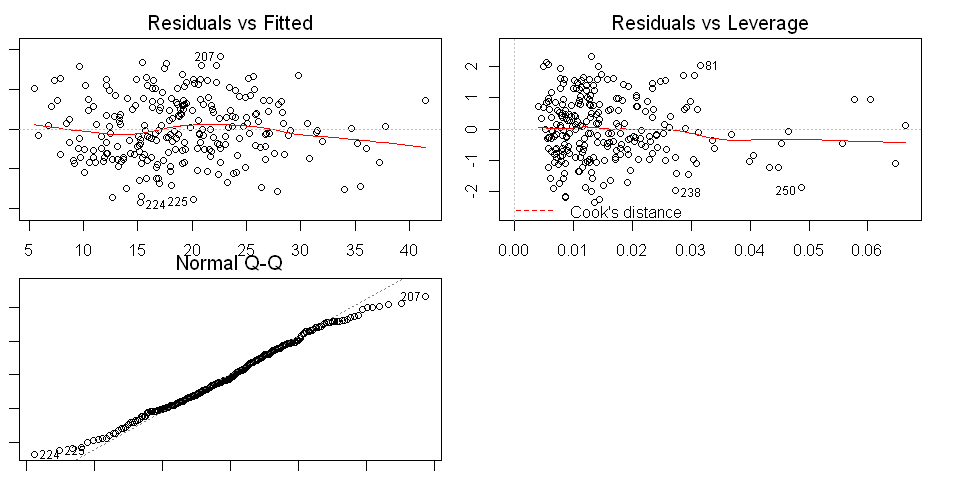

In [348]:
layout(matrix(1:4, ncol=2))
par(mar = c(1, 1, 2, 2), cex = 0.8)
plot(final.model,c(1,5,2))
#vif(final.model)
options(repr.plot.width=8, repr.plot.height=4)

# Rules of thumb
weight(lbs) multiplied by -0.1 plus abdomen(cm) multiplied by 0.9 plus wrist(cm) multiplied by -1.3 minus 23.0  
$$bodyfat = -23.0 - 0.1*WEIGHT + 0.9*ABDOMEN - 1.3*WRIST$$
# Example
For a 180lbs man with 95 abdomen circumference and 18 wrist circumference, his predicted bodyfat would be around 21.
# Interpretation
You may be confused with parameter -0.09 because fat person has larger weight.  
But based on "a pound of muscle occupies less space than a pound of fat", if we suppose two people have the same abdomen and wrist, that's to say their volume are similar, muscle man weighted higher than fat man and that's why the parameter is negative. For wrist, it represent your skeleton and it's inborn.Let's imagine two people with similarly-sized skeleton and fat man should have larger abdomen. Similarly, the people who have larger wrist is likely to be a muscle man.Therefore the parameter of abdomen is positive and the parameter of wrist is negative.
# Strength and Weakness
Our model is simple and it leads to robustness.Also, the model is easy to interpret with explicit coeficients.
but we need to do feature engineering to create more features and we may get a better model.for example, we have known muscle man have larger wrist and smaller abdomen and we can use abdomen/wrist as a new feature and since 'a pound of muscle occupies less space than a pound of fat',we can create new features by weight divided by other features, like weight/wrist and weight/abdomen.Basicly wrist and abdomen stand for volumn.  
Besides,qq plot shows a person has too large or too small bodyfat will not be estimated correctly.so we can use a complex model,for example we can do classification at first step if we have more data.
# Reference
[1] https://insightr.wordpress.com/2017/06/14/when-the-lasso-fails/ <br>
[2]  Efroymson,M. A. (1960) "Multiple regression analysis," Mathematical Methods for Digital Computers, Ralston A. and Wilf,H. S., (eds.), Wiley, New York.
# Contribution
Jiaming Zhou: Background research, Data Cleaning, Mallows's Cp, slides, notebook, shiny  
Lijie Liu: Lasso, AIC, Result, notebook, slides  
Xiangan Zhang: BIC,Result, notebook, slides  